## Training for Random Forest begins here

In [18]:
import wandb
import ydf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
import numpy as np

# wandb.init(project='stonks')

norm = False
learners = []
subdir = 'norm' if norm else 'unnorm'

tdf = []
vdf = []
for i in range(11):
    train_df = pd.read_csv(f'covset2/train_{i}.csv')
    valid_df = pd.read_csv(f'covset2/valid_{i}.csv')
    
    tdf.append(train_df)
    vdf.append(valid_df)

train_data = pd.read_csv(f'covset3_full/train_top_5.csv')
valid_data = pd.read_csv(f'covset3_full/valid_top_5.csv')


In [19]:
import numpy as np
label = 'TOP_5'

# learner = ydf.RandomForestLearner(task=ydf.Task.CLASSIFICATION, label=label, num_trees=10000,
#                                   winner_take_all=False, growing_strategy='BEST_FIRST_GLOBAL').train(train_data)

learner = (ydf.RandomForestLearner(task=ydf.Task.CLASSIFICATION,
                                        label='TOP_5',
                                        max_depth = 25,
                                        # growing_strategy='BEST_FIRST_GLOBAL',
                                        num_trees=1000).train(train_data))

valid_preds = learner.predict(valid_data.drop('TOP_5', axis=1, inplace=False))
# Assuming valid_preds contains the probabilities of class 1
threshold = 0.5
predicted_classes = (valid_preds >= threshold).astype(int)

# Now create a DataFrame for the predictions
preds = pd.DataFrame({
    'Predicted': predicted_classes,
    'Probs': valid_preds
})

# Ensure consistency in lengths and alignment
true_classes = valid_data["TOP_5"].reset_index(drop=True)
predicted_classes = preds['Predicted'].reset_index(drop=True)

# Check if lengths match
assert len(true_classes) == len(predicted_classes), "Lengths of true and predicted classes do not match."

# Calculate accuracies
total_accuracy = np.mean(true_classes == predicted_classes)

print("Accuracy: ", total_accuracy)


Train model on 70075 examples
Model trained in 0:02:04.707795
Accuracy:  0.8054726368159204


In [22]:
valid_data['Predicted'] = preds['Predicted']

In [29]:
crossval_data = valid_data.loc[:, ["index", "VOLATILITY_20", 'TOP_5', 'Ticker', 'Predicted', "PCT_CHANGE_20"]]

In [30]:
crossval_data

,index,VOLATILITY_20,TOP_5,Ticker,Predicted,PCT_CHANGE_20
0,2012-01-09-0,13.616070,1,ACES,0,10.047847
1,2012-01-10-0,13.487909,1,ACES,0,8.536585
2,2012-01-11-0,13.295824,1,ACES,0,8.354430
3,2012-01-12-0,13.401100,1,ACES,0,14.690722
4,2012-01-13-0,13.164846,1,ACES,0,11.959288
...,...,...,...,...,...,...
16075,2024-02-23-26,43.197831,1,PTBA,0,11.787072
16076,2024-02-26-26,42.723099,1,PTBA,0,13.565891
16077,2024-02-27-26,42.723099,1,PTBA,0,13.513514
16078,2024-02-28-26,42.732337,1,PTBA,0,12.595420


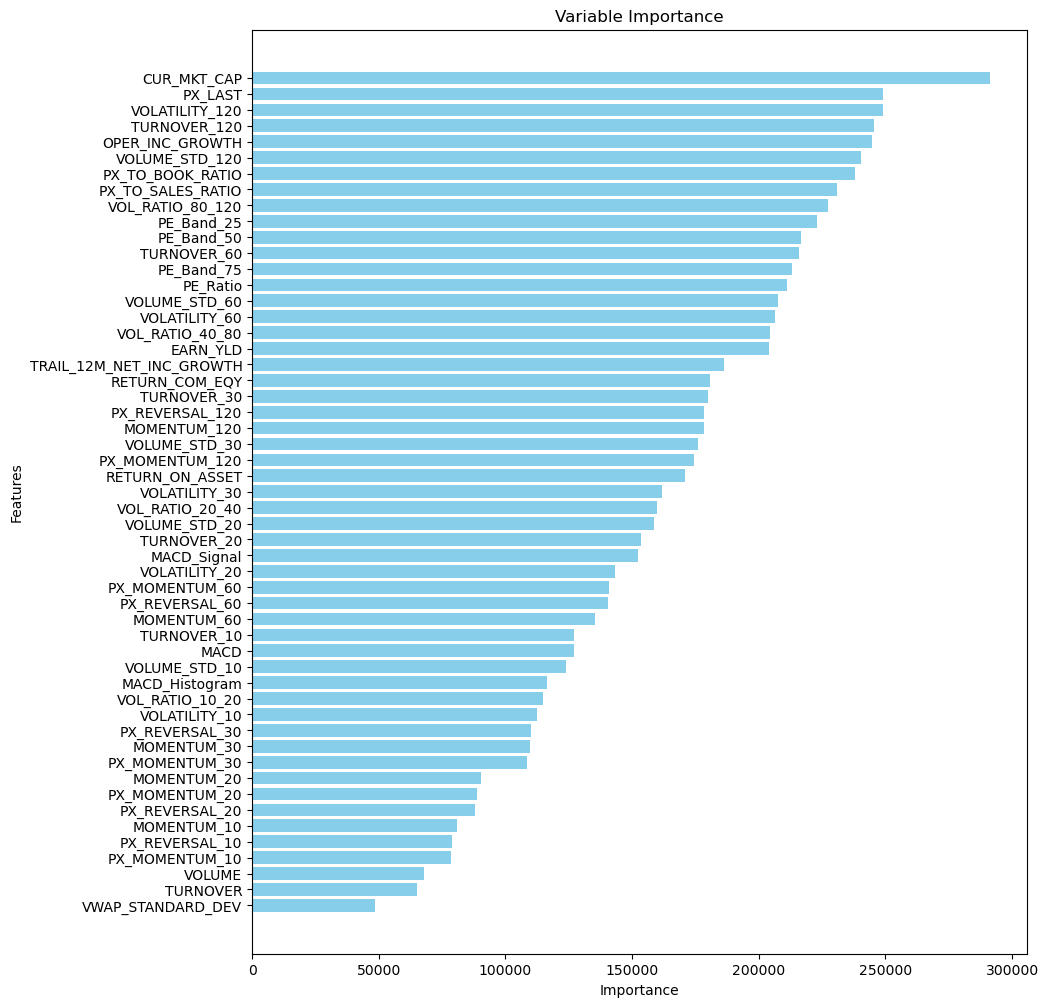

In [15]:
variable_importance = learner.variable_importances()['SUM_SCORE']

# Unzip the variable importance into two lists
importance_values, features = zip(*variable_importance)

# Plotting
plt.figure(figsize=(10, 12))
plt.barh(features, importance_values, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Variable Importance')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In [16]:
train_data = pd.read_csv(f'covset3_full/train_quintiles.csv')
valid_data = pd.read_csv(f'covset3_full/valid_quintiles.csv')

label = 'DELTA_20_QUINTILES'
learner1 = (ydf.RandomForestLearner(task=ydf.Task.CLASSIFICATION,
                                   label=label,
                                   categorical_algorithm='CART',
                                   max_depth=25,
                                   # growing_strategy='BEST_FIRST_GLOBAL',
                                   num_trees=300).train(train_data))

valid_preds = learner1.predict(valid_data)
preds = pd.DataFrame(valid_preds, columns=learner1.label_classes())
preds['Probs'] = preds.max(axis=1)
preds['Predicted'] = preds.idxmax(axis=1)

# Ensure consistency in lengths and alignment
true_classes = valid_data["DELTA_20_QUINTILES"].reset_index(drop=True)
predicted_classes = preds['Predicted'].astype(int).reset_index(drop=True)

# Check if lengths match
assert len(true_classes) == len(predicted_classes), "Lengths of true and predicted classes do not match."

# Create the filter mask for classes 1 and 5
filter_mask = (true_classes.isin([1, 5])) | (predicted_classes.isin([1, 5]))

# Apply the filter
filtered_tclass = true_classes[filter_mask]
filtered_pclass = predicted_classes[filter_mask]

# Calculate accuracies
total_accuracy = accuracy_score(true_classes, predicted_classes)
onefive_accuracy = accuracy_score(filtered_tclass, filtered_pclass)

print("Accuracy: ", total_accuracy)
print("1/5 accuracy: ", onefive_accuracy)

# Define the penalty matrix
weight = 0.5
penalty_matrix = np.array([
    [0, weight, 1, 1, 1],  # True class is 1
    [weight, 0, 1, 1, 1],  # True class is 2
    [1, 1, 0, 1, 1],  # True class is 3
    [1, 1, 1, 0, weight],  # True class is 4
    [1, 1, 1, weight, 0],  # True class is 5
])

# Convert the true and predicted classes to numpy arrays for easier indexing
true_classes = valid_data["DELTA_20_QUINTILES"].to_numpy()
predicted_classes = preds['Predicted'].astype(int).to_numpy()

# Initialize a list to store penalties for each prediction
penalties = []

# Loop through each prediction and calculate the penalty
for true_class, pred_class in zip(true_classes, predicted_classes):
    penalty = penalty_matrix[true_class - 1, pred_class - 1]
    penalties.append(penalty)

# Calculate total weighted accuracy
weighted_accuracy = 1 - np.mean(penalties)

# Print the weighted accuracy
print("Coping Accuracy: ", weighted_accuracy)
valid_data

Train model on 70075 examples
Model trained in 0:01:05.275843
Accuracy:  0.3306592039800995
1/5 accuracy:  0.2873920899417788
Coping Accuracy:  0.4099502487562189


,index,EARN_YLD,PX_TO_BOOK_RATIO,PX_TO_SALES_RATIO,RETURN_ON_ASSET,RETURN_COM_EQY,CUR_MKT_CAP,TRAIL_12M_NET_INC_GROWTH,OPER_INC_GROWTH,VWAP_STANDARD_DEV,...,VOLUME_STD_60,MOMENTUM_120,TURNOVER_120,PX_MOMENTUM_120,PX_REVERSAL_120,VOLATILITY_120,VOLUME_STD_120,DELTA_20_CHANGE,Ticker,DELTA_20_QUINTILES
0,2012-01-09-0,3.9822,5.9339,2.9712,21.5209,25.7245,7160125.00,66.7596,145.6842,1.0,...,1.602701e+07,1.177465,2.400110e+09,1.177465,0.849282,30.001569,1.634037e+07,8.341013,ACES,5
1,2012-01-10-0,4.0551,5.8273,2.9178,21.5209,25.7245,7031500.00,66.7596,145.6842,3.0,...,1.602055e+07,1.171429,2.405607e+09,1.171429,0.853659,30.461051,1.633551e+07,7.270807,ACES,5
2,2012-01-11-0,4.2090,5.6141,2.8111,21.5209,25.7245,6774250.00,66.7596,145.6842,4.0,...,1.602242e+07,1.135057,2.413459e+09,1.135057,0.881013,30.701325,1.632893e+07,6.580661,ACES,5
3,2012-01-12-0,4.2905,5.5075,2.7577,21.5209,25.7245,6645625.00,66.7596,145.6842,1.0,...,1.602248e+07,1.124638,2.429096e+09,1.124638,0.889175,30.856635,1.631989e+07,14.616646,ACES,5
4,2012-01-13-0,4.2359,5.5786,2.7933,21.5209,25.7245,6731375.00,66.7596,145.6842,2.0,...,1.599970e+07,1.139130,2.430938e+09,1.139130,0.877863,31.056644,1.631852e+07,11.283969,ACES,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16075,2024-02-23-26,20.2105,1.4095,0.7849,14.5163,24.3554,30299333.83,-51.4158,-1.9939,7.0,...,5.367779e+06,0.897611,2.984318e+10,0.897611,1.114068,162.216765,6.561726e+06,10.819724,PTBA,5
16076,2024-02-26-26,20.6021,1.3827,0.7700,14.5163,24.3554,29723300.87,-51.4158,-1.9939,11.0,...,5.358781e+06,0.895833,2.969968e+10,0.895833,1.116279,159.768719,6.545349e+06,13.205243,PTBA,5
16077,2024-02-27-26,20.5226,1.3880,0.7730,14.5163,24.3554,29838507.46,-51.4158,-1.9939,6.0,...,5.361696e+06,0.902439,2.956430e+10,0.902439,1.108108,157.413419,6.566144e+06,13.465527,PTBA,5
16078,2024-02-28-26,20.2876,1.4041,0.7820,14.5163,24.3554,30184127.24,-51.4158,-1.9939,5.0,...,5.388702e+06,0.925795,2.915318e+10,0.925795,1.080153,155.657096,6.511567e+06,14.281614,PTBA,5


In [6]:
learner1.variable_importances()['SUM_SCORE']

[(4405593.211530692, 'CUR_MKT_CAP'),
 (4052677.188985249, 'VOLATILITY_120'),
 (4036058.483155931, 'TURNOVER_120'),
 (3721548.199567952, 'TURNOVER_60'),
 (3691681.520064926, 'VOLUME_STD_120'),
 (3677206.6871537715, 'VOL_RATIO_80_120'),
 (3643812.755849935, 'PX_TO_SALES_RATIO'),
 (3624493.318787601, 'VOLATILITY_60'),
 (3565019.6339351577, 'PX_TO_BOOK_RATIO'),
 (3395000.636581225, 'VOLUME_STD_60'),
 (3296289.853933057, 'VOL_RATIO_40_80'),
 (3286613.0182786174, 'PX_LAST'),
 (3269810.6047877125, 'PE_Band_50'),
 (3205668.15111272, 'PE_Band_25'),
 (3109606.673889471, 'EARN_YLD'),
 (3105798.9939749995, 'PE_Band_75'),
 (3096742.499601577, 'TURNOVER_30'),
 (3028180.2066660617, 'PE_Ratio'),
 (3008513.5198208294, 'VOLUME_STD_30'),
 (2864840.491253738, 'OPER_INC_GROWTH'),
 (2819766.7375852764, 'VOLATILITY_30'),
 (2787296.327583434, 'MACD_Signal'),
 (2762511.703732062, 'VOLUME_STD_20'),
 (2726178.0202283533, 'TURNOVER_20'),
 (2667936.9443577994, 'VOL_RATIO_20_40'),
 (2551510.3327225195, 'MOMENTUM_12

In [20]:
preds

,Predicted,Probs
0,0,0.493997
1,0,0.418998
2,0,0.405998
3,0,0.409998
4,0,0.395998
...,...,...
16075,0,0.404998
16076,0,0.320999
16077,0,0.317999
16078,0,0.321999
